In [3]:
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib as mpl
import scipy.stats as stats
import scipy.special as special
# import quad
from scipy.integrate import quad
from scipy.special import erf
from scipy.special import dawsn
from scipy.optimize import root
import scipy.io as sio
import scipy.interpolate as interpolate
from scipy.interpolate import CubicSpline

from matplotlib.patches import Rectangle, FancyBboxPatch
from matplotlib import patches
from matplotlib import text as mtext
import math
from common_functions import CurvedText, make_figure_set_width
from common_functions import folded_sojourn_time as sojourn_time
from common_functions import fixation_probability_steady_state as probability_fixation


In [7]:
# this is the file to get the ssd from Simons et al 2022.
data = sio.loadmat('./Simons_2022_SSD_dfe.mat')
thing1, thing2 = data['figdata'][0][0]
ssd_plots = thing1[0][0]
s_values = 10**(np.reshape(ssd_plots[0],[129,1])[:,0])*2*20000
pdf_values = np.reshape(ssd_plots[1],[129,1])[:,0]
# we fit a cubic spline to the ssd data for interpolation
ff = CubicSpline(s_values,pdf_values)



In [ ]:
# functions to calculate variance contributions
def get_variance_from_new_background_fixations_given_a2(a2,N):
    a = np.sqrt(a2)
    return a2/2*probability_fixation(a=a,x=1/(2*N))

def get_variance_from_background_fixations_seg_given_a2(a2,N):
    a = np.sqrt(a2)
    return quad(lambda x: a2/2*probability_fixation(a=a,x=x)*sojourn_time(a=np.sqrt(a2),x=x,N=N), 0, 1/2, points=[1/(2*N)])[0]

def get_variance_from_segregating_alleles_given_a(a2,N):
    return quad(lambda x: 2*a2*(x/2)*(1-x/2)*sojourn_time(a=np.sqrt(a2),x=x,N=N), 0, 1/2, points=[1/(2*N)])[0]

def get_v_divergence_per_mutational_input(N,sdist):
    new = 2*quad(lambda a2: get_variance_from_new_background_fixations_given_a2(a2=a2,N=N)*sdist.pdf(a2),0,sdist.ppf(0.9999),points=[sdist.ppf(0.01),sdist.ppf(0.99)])[0]
    seg = 2*quad(lambda a2: get_variance_from_background_fixations_seg_given_a2(a2=a2,N=N)*sdist.pdf(a2),0,sdist.ppf(0.9999),points=[sdist.ppf(0.01),sdist.ppf(0.99)])[0]
    return new,seg

def get_v_polymorphism_per_mutational_input(N,sdist):
    seg = 2*quad(lambda a2: get_variance_from_segregating_alleles_given_a(a2=a2,N=N)*sdist.pdf(a2),0,sdist.ppf(0.9999),points=[sdist.ppf(0.01),sdist.ppf(0.99)])[0]
    return seg

def get_variance_contribution_given_a2(a2,N):
    return quad(lambda x: 2*x*(1-x)*a2*sojourn_time(a=np.sqrt(a2),x=x,N=N),0,1/2,points=[1/(2*N)])[0]
    
def get_variance_contribution_per_mutational_input(N,sdist):
    seg = quad(lambda a2: get_variance_contribution_given_a2(a2=a2,N=N)*sdist.pdf(a2),0,sdist.ppf(0.9999),points=[sdist.ppf(0.01),sdist.ppf(0.99)])[0]
    return seg

def get_mutational_input(Va,sdist,N):
    seg = get_variance_contribution_per_mutational_input(N,sdist)
    U = Va/(seg*2*N)
    return U

def slope_intercept(Va,sdist,N):
    U = get_mutational_input(Va,sdist,N)
    new,seg = get_v_divergence_per_mutational_input(N,sdist)
    new = new*2*N*U
    seg = seg*2*N*U
    v_poly = get_v_polymorphism_per_mutational_input(N,sdist)*2*N*U
    intercept = v_poly#+seg
    slope = new
    return slope,intercept

def calculate_V_total(T,slope,intercept,h2):
    Va = T*slope+intercept+100/2
    V_total = Va/h2
    return V_total

def calculate_he(T,slope,intercept,h2,a2):
    return (a2/2)/calculate_V_total(T,slope,intercept,h2)


In [9]:
def get_power(T,slope,intercept,h2,a2,n,alpha):
    he = calculate_he(T,slope,intercept,h2,a2)
    noncentrality_parameter = n*he
    f_central = stats.f(dfn=1,dfd=n)
    f_noncentral = stats.ncf(dfn=1,dfd=n,nc=noncentrality_parameter)
    lambda_alpha = f_central.ppf(1-alpha)
    beta = f_noncentral.cdf(lambda_alpha)
    power = 1 - beta
    return power,he
    
def get_sample_size_needed_for_minimum_power(T,slope,intercept,h2,a2,min_power,alpha,default_n = 100):
    sol = root(lambda n: get_power(T,slope,intercept,h2,a2,n,alpha)[0] - min_power,default_n)
    if sol.success or default_n != 100:
        return sol.x[0]
    else:
        return get_sample_size_needed_for_minimum_power(T,slope,intercept,h2,a2,min_power,alpha,default_n = 10)
    


In [10]:
def calculate_min_sample_sizes_for_T(sdist,N,Va,times,h2,a2,min_power,alpha):
    slope,intercept = slope_intercept(Va=Va,sdist=sdist,N=N)
    power = []
    for t in times:
        power.append(get_sample_size_needed_for_minimum_power(T=t,slope=slope,intercept=intercept,h2=h2,a2=a2,min_power=min_power,alpha=alpha))
    return power

def calculate_power_given_n_for_T(sdist,N,Va,times,h2,a2,n,alpha):
    slope,intercept = slope_intercept(Va=Va,sdist=sdist,N=N)
    power = []
    for t in times:
        power.append(get_power(t,slope,intercept,h2,a2,n,alpha))
    return power


In [ ]:
# define the DFEs we will use
class CustomSDist:
    def __init__(self):
        self.small_effect_distribution = stats.expon(loc=0,scale=1)
        self.large_effect_distribution = stats.expon(loc=100,scale=400)
        self.p = 0.5
    
    def pdf(self,a2):
        return self.small_effect_distribution.pdf(a2)*(1-self.p)+self.large_effect_distribution.pdf(a2)*self.p
    
    def cdf(self,a2):
        return self.small_effect_distribution.cdf(a2)*(1-self.p)+self.large_effect_distribution.cdf(a2)*self.p
    
    def ppf(self,q):
        if q < self.p:
            default = self.small_effect_distribution.ppf(q*2)
        else: 
            default = self.large_effect_distribution.ppf((q-0.5)*2)
        sol = root(lambda a2: self.cdf(a2)-q,default)
        if sol.success:
            return sol.x[0]
        else:
            print(q,default)
            print(sol)
            raise ValueError

expon_mixture = CustomSDist()
loguniform = stats.loguniform(0.01,1000)


In [ ]:
class YuvalSdist:
    def __init__(self):
        self.x = s_values
        self.y = pdf_values
        self.interpolation = ff
        self.cdf_total = 0
        self.max_x = 100
        self.min_x = min(self.x)
        
    def __initialize__(self):
        self.cdf_total = quad(lambda aa: self.pdf(aa),self.min_x,self.max_x)[0]
        
    def pdf(self,a2):
        return max(0,self.interpolation(a2))
    
    def cdf(self,a2):
        return quad(lambda aa: self.pdf(aa),0,a2)[0]/self.cdf_total
    
    def ppf(self,q):
        return root(lambda a2: self.cdf(a2)-q,1).x[0]
    
    
yy = YuvalSdist()
yy.__initialize__()
yy.cdf(10)


0.8793113986917351 0.0004 40000.0


0.2786632093294737

In [13]:
# set parameters
alpha = 0.05
min_power = 0.9
h2 = 0.5
N = 5000
Va = 100
a2 = 100
times = np.linspace(0,20,1000)*N
n = 200

# calculate results
results_dict = {}
for Va,ls in zip([100,300],['-','--']):
    results_dict[Va] = {}
    for sdist,color in zip([expon_mixture,loguniform,yy],['cornflowerblue','firebrick','purple']):
        results_dict[Va][sdist] = (calculate_min_sample_sizes_for_T(sdist,N,Va,times,h2,a2,min_power,alpha),calculate_power_given_n_for_T(sdist,N,Va,times,h2,a2,n,alpha))


Adjusting figure width from 6.50 to 7.09 inches to achieve target width of 6.50 inches.


Adjusting figure width from 7.09 to 7.29 inches to achieve target width of 6.50 inches.


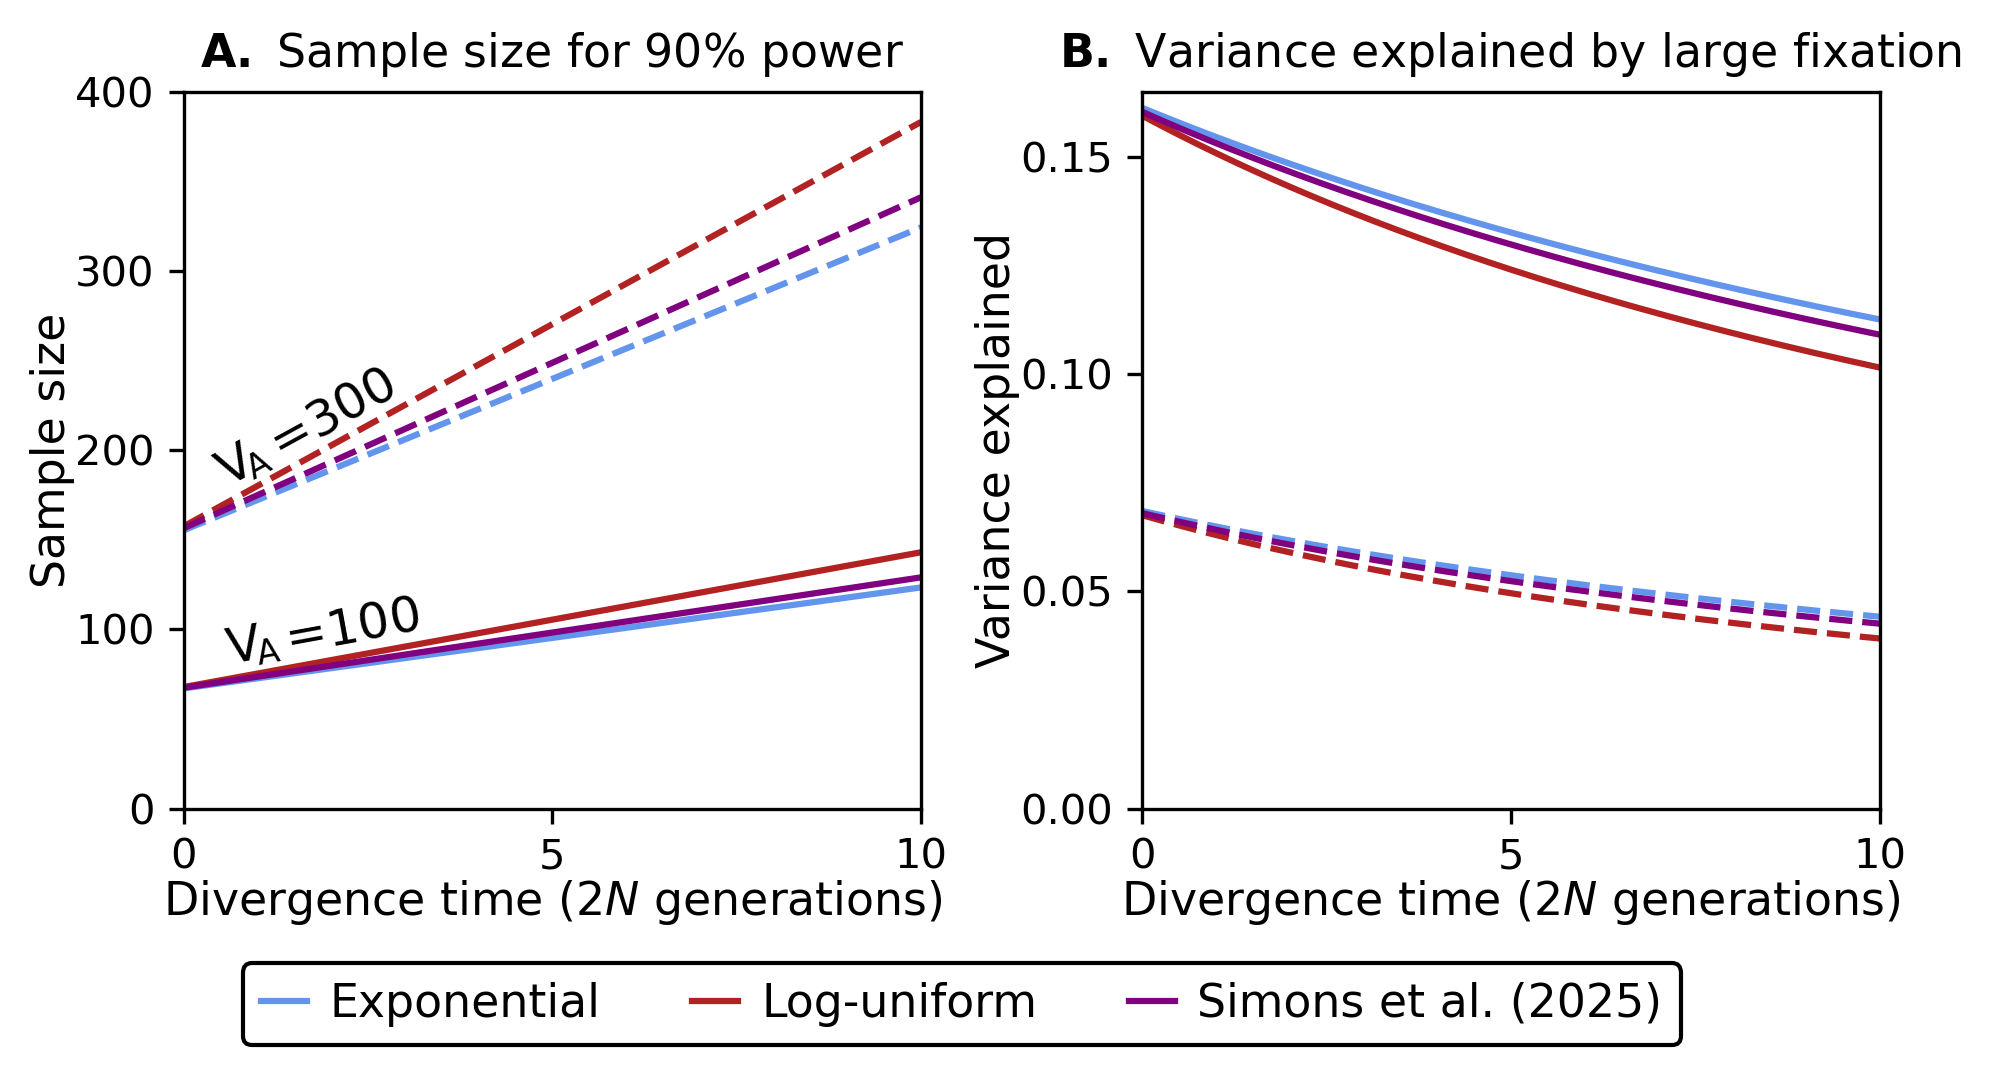

In [17]:
def create_figure(fig_height,fig_width):
    fig,axes = plt.subplots(ncols=2,dpi=300,figsize=(fig_width,fig_height))
    fontsize = 11
    ax = axes[0]
    plt.sca(ax)
    for Va,ls in zip([100,300],['-','--']):
        for sdist,color in zip([expon_mixture,loguniform,yy],['cornflowerblue','firebrick','purple']):
            min_sample_size = results_dict[Va][sdist][0]
            plt.plot(times/(2*N),min_sample_size,color=color,ls=ls)
            
            if color == 'firebrick':
                t0 = int(1000/20)
                t1 = int(1000/20*2)
                CurvedText(axes=ax,x=times[t0:]/(2*N),y=np.array(min_sample_size[t0:])+8,text=f'V ={Va}',color='k',size=12)
                CurvedText(axes=ax,x=times[t0:]/(2*N)+0.1/2,y=np.array(min_sample_size[t0:])+5,text=f' A',color='k',size=8)

    plt.xlim([0,10])
    plt.ylim([0,400])
    plt.xticks(np.linspace(0,10,3))
    plt.yticks([0,100,200,300,400])
    plt.xlabel('Divergence time ($2N$ generations)',size=fontsize,labelpad=0)
    plt.ylabel('Sample size',size=fontsize,labelpad=0)
    plt.title(r'$\bf{A.}$ Sample size for 90% power',size=fontsize)
    plt.plot([],[],color='cornflowerblue',label='Exponential')
    plt.plot([],[],color='firebrick',label='Log-uniform')
    plt.plot([],[],color='purple',label='Simons et al. (2025)')
    plt.legend(framealpha=1,edgecolor='k',fontsize=fontsize,handlelength=1,handletextpad=0.5,ncol=3,loc=(0.08,-0.33))

    ax = axes[1]
    plt.sca(ax)
    for Va,ls in zip([100,300],['-','--']):
        for sdist,color in zip([expon_mixture,loguniform,yy],['cornflowerblue','firebrick','purple']):
            power = np.array([i[1] for i in results_dict[Va][sdist][1]])
            plt.plot(times/N,power,color=color,ls=ls)
            
            if color == 'firebrick':
                t0 = int(1000/20)
                t1 = int(1000/20*2)
                CurvedText(axes=ax,x=times[t0:]/(2*N),y=np.array(power[t0:])+8,text=f'V ={Va}',color='k',size=10)
                CurvedText(axes=ax,x=times[t0:]/(2*N)+0.1,y=np.array(power[t0:])+5,text=f' A',color='k',size=6)

    plt.xlim([0,10])
    plt.xticks(np.linspace(0,10,3))
    plt.ylim([0,0.165])
    plt.yticks([0,0.05,0.1,0.15])
    plt.title(r'$\bf{B.}$ Variance explained by large fixation',size=fontsize)
    plt.xlabel('Divergence time ($2N$ generations)',size=fontsize,labelpad=0)
    plt.ylabel('Variance explained',size=fontsize,labelpad=0)
    plt.subplots_adjust(wspace=0.3)

    bbox = ax.get_window_extent()

    # Convert the bounding box to inches using the figure's DPI
    width_inches = bbox.width / fig.dpi
    height_inches = bbox.height / fig.dpi
    return fig, fig_width, fig_height, width_inches, height_inches 

make_figure_set_width(filename='./Figures/Figure_S16.png',fig_function=create_figure,target_width_inches=6.5,fig_height=3,fig_width=6.5)
